In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import glob
import h5py

In [ ]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

In [ ]:
torch.__version__

In [ ]:
gpu = 0
multi_gpus = None #[0, 1, 2]
b = 12
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [ ]:
# load mask
mask = None

In [ ]:
train_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [ ]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [ ]:
new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=0.2, random_state=42)

In [ ]:
train_sampler = SubsetRandomSampler(new_ind)

In [ ]:
# define dataset

In [ ]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [ ]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [ ]:
if zero_one_normalize:
    intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [ ]:
sample = adni_data_test[-1]
img = sample["image"]
print(img.shape)
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [ ]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        
        self.classifier_scratch = nn.Sequential(
            nn.Linear(1296, 80),
            nn.Linear(80, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [ ]:
print(net)

In [ ]:
print("Trainable model parameters: {}".format(count_parameters(net)))

# Training

In [21]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=10,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies: {}".format(best_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models


In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 65
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [27]:
r = 0

In [28]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/20_percent/baseline/"
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
torch.Size([1, 96, 114, 96])
12


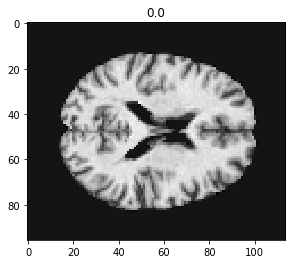

RuntimeError: CUDA out of memory. Tried to allocate 2.83 GiB (GPU 0; 10.92 GiB total capacity; 2.88 GiB already allocated; 1.11 GiB free; 1.18 MiB cached)

In [25]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [ ]:
5/0

# Start inference

### Using best model checkpoint for inference

In [29]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [30]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [31]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 78.900 %
ROC AUC Score 91.244 %
Sensitivity 86.667 %
Specificity 71.134 %
Fold 1
Bal. accuracy 76.997 %
ROC AUC Score 84.454 %
Sensitivity 65.333 %
Specificity 88.660 %
Fold 2
Bal. accuracy 81.938 %
ROC AUC Score 92.962 %
Sensitivity 68.000 %
Specificity 95.876 %
Fold 3
Bal. accuracy 78.687 %
ROC AUC Score 90.048 %
Sensitivity 89.333 %
Specificity 68.041 %
Fold 4
Bal. accuracy 79.148 %
ROC AUC Score 88.027 %
Sensitivity 70.667 %
Specificity 87.629 %
Fold 5
Bal. accuracy 79.567 %
ROC AUC Score 91.588 %
Sensitivity 88.000 %
Specificity 71.134 %
Fold 6
Bal. accuracy 73.381 %
ROC AUC Score 88.825 %
Sensitivity 88.000 %
Specificity 58.763 %
Fold 7
Bal. accuracy 85.485 %
ROC AUC Score 92.976 %
Sensitivity 72.000 %
Specificity 98.969 %
Fold 8
Bal. accuracy 81.485 %
ROC AUC Score 94.914 %
Sensitivity 64.000 %
Specificity 98.969 %
Fold 9
Bal. accuracy 81.512 %
ROC AUC Score 89.993 %
Sensitivity 73.333 %
Specificity 89.691 %
######## Final results ########
    Bal Acc   ROC 